In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [89]:
df = pd.read_csv('../datafiles/CO_2014_2015.csv')
df.shape

(139616, 45)

In [90]:
cols = ['Age', 'CustomerLifetimeSpend',
       #'Customer1YearSpend', 
       'Customer3YearSpend', 'ThreeYearVisitCount',
       'SkiLoyaltyIndexRating', 'FrontRangeMarket',
       'Spend_Winter_2010', 'Spend_Winter_2011', 'Spend_Winter_2012',
       'Spend_Winter_2013', 'Spend_Winter_2014', #'Spend_Winter_2015',
       #'Household1YearSpend',
       'Household3YearSpend', 'HouseholdLifetimeSpend',
       'NumberOfHouseholdMembers', 'NumberOfAdults',
       'NumberOfChildren', 'Pass_Winter_2010', 'Pass_Winter_2011',
       'Pass_Winter_2012', 'Pass_Winter_2013', 'Pass_Winter_2014',
       'Early_Purchase_2014_2015', 'Regular_Purchase_2014_2015',
       'Late_Purchase_2014_2015', 'Super_Late_Purchase_2014_2015', 'January_15', 'February_15', 'March_15',
       'April_15', 'November_14', 'December_14', 'Total_Days_14_15', 'Total_Days_13_14', 
       'Ski_Resort1_2014_2015',
       'Ski_Resort2_2014_2015', 'Ski_Resort3_2014_2015', 'Ski_Resort4_2014_2015', 'Ski_Resort5_2014_2015']

#### Assigning X and y

In [91]:
X = df[cols]
y = df['Pass_Winter_2015']

### Baseline for Previous Pass Customers purchasing a 2015/2016 Pass

In [92]:
df['Pass_Winter_2015'].mean()

0.4682128122851249

#### Mean of Winter 2015 passes based on if they had a 2014 Pass

In [93]:
df.groupby('Pass_Winter_2014')['Pass_Winter_2015'].mean()

Pass_Winter_2014
0    0.335668
1    0.631750
Name: Pass_Winter_2015, dtype: float64

#### Train, Test, Split of X and y

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [95]:
y_train.mean()

0.46732943693177476

In [96]:
y_test.mean()

0.47086293834517534

#### Scaling the data for some of the models

In [97]:
ss = StandardScaler()
# Fit Scaler on X_train data from TTS
ss.fit(X_train)
# Transform X_Train data from TTS
X_train_scaled = ss.transform(X_train)
#Transform X_test from TTS
X_test_scaled = ss.transform(X_test)

### Scaled Logistic Regression

In [98]:
%%time
#Instantiate model.
logreg = LogisticRegression()
#Fit model.
logreg.fit(X_train_scaled, y_train)
# After fitting: Print out intercept and coefficients.
print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)
print('Logreg Training CrossVal score:', cross_val_score(logreg, X_train_scaled, y_train).mean())
print('Logreg Testing score:', logreg.score(X_test_scaled,y_test))

Logreg intercept: [0.07248023]
Logreg coef(s): [[-8.12111295e-02 -4.87967734e-01  1.44218291e+00  2.74497348e-01
  -1.17078441e-01  7.68932955e-02  2.32923494e-02  5.20209961e-03
   1.45846580e-02 -1.09695956e-01 -1.40721366e-01  2.14854757e+00
  -1.24104022e+00 -1.76163831e+00  1.15005729e+00  9.03451266e-01
  -1.99049831e-01 -1.69881634e-01  1.33969752e-01  6.59998549e-02
   6.59978250e-02  2.63496466e-01  2.35083465e-02 -1.37210480e-01
  -9.35203445e-02  7.26006035e-02  1.58282430e-01  1.48886020e-01
   1.10094052e-02 -9.25607616e-02 -9.74272601e-02  6.38846379e-02
   2.98015719e-02 -1.60452336e-02 -1.23999844e-02 -1.28106584e-01
  -1.33831562e-04  2.78324009e-01]]
Logreg Training CrossVal score: 0.7336504162971677
Logreg Testing score: 0.731692642677057
CPU times: user 11.4 s, sys: 415 ms, total: 11.8 s
Wall time: 12.9 s


### Non-scaled Logistic Regression

In [99]:
%%time
#Instantiate model.
logreg = LogisticRegression()
#Fit model.
logreg.fit(X_train, y_train)
# After fitting: Print out intercept and coefficients.
print('Logreg Training CrossVal score:', cross_val_score(logreg, X_train, y_train).mean())
print('Logreg Testing score:', logreg.score(X_test,y_test))

Logreg Training CrossVal score: 0.7341565629431587
Logreg Testing score: 0.7310050424020169
CPU times: user 15.4 s, sys: 339 ms, total: 15.7 s
Wall time: 16 s


### There is virtually no difference in the Scaled vs Non-Scaled, so I am going to work with the Non-Scaled model for deeper analysis and tuning.

#### Exponentiate the coefficients to improve readability

In [100]:
list(zip(X.columns, np.exp(logreg.coef_[0])))

[('Age', 0.9945004858357662),
 ('CustomerLifetimeSpend', 0.9998515830687781),
 ('Customer3YearSpend', 1.000823574399601),
 ('ThreeYearVisitCount', 1.0139203460187205),
 ('SkiLoyaltyIndexRating', 0.9732665322889624),
 ('FrontRangeMarket', 1.2024282933152153),
 ('Spend_Winter_2010', 1.0003827522159576),
 ('Spend_Winter_2011', 1.0000794406858982),
 ('Spend_Winter_2012', 1.0002034236882846),
 ('Spend_Winter_2013', 0.9986982746317093),
 ('Spend_Winter_2014', 0.9985180623190255),
 ('Household3YearSpend', 1.0006054186926843),
 ('HouseholdLifetimeSpend', 0.9997019683740387),
 ('NumberOfHouseholdMembers', 0.9177719511490586),
 ('NumberOfAdults', 0.9752411651878385),
 ('NumberOfChildren', 0.9551783548161913),
 ('Pass_Winter_2010', 0.561086860651145),
 ('Pass_Winter_2011', 0.6758263382058886),
 ('Pass_Winter_2012', 1.35672380989086),
 ('Pass_Winter_2013', 1.1879090167936843),
 ('Pass_Winter_2014', 1.135258391805119),
 ('Early_Purchase_2014_2015', 2.3155742950511597),
 ('Regular_Purchase_2014_2015

## Code to plot importance of coefficients

In [101]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

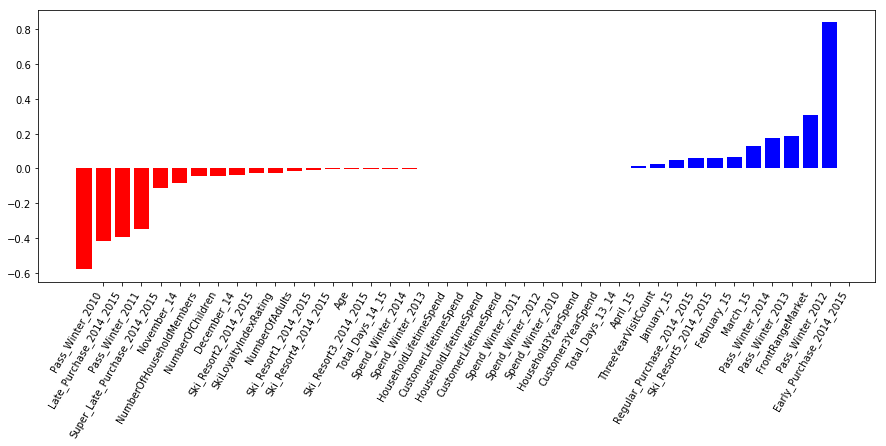

In [102]:
plot_coefficients(logreg,X.columns)

In [103]:
predictions = logreg.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))

Accuracy: 73.10%


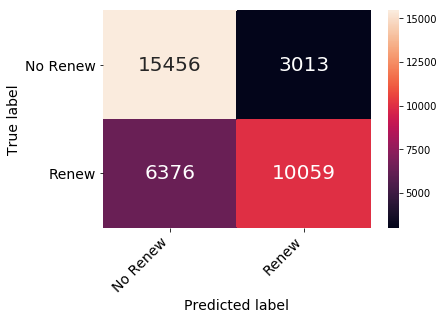

In [104]:
confusion_matrix_lr = confusion_matrix(y_test, predictions)
confusion_matrix_df = pd.DataFrame(confusion_matrix_lr, ('No Renew', 'Renew'), ('No Renew', 'Renew'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show();

#### Store predictions dataframe for analysis

In [105]:
predictions_proba = logreg.predict_proba(X_test)
df_lr = pd.DataFrame(y_test)
df_lr.loc[:, 'actual_y'] = y
df_lr.loc[:, 'predicted_label'] = predictions
df_lr.loc[:, 'predicted_proba'] = predictions_proba[:, 1]
df_lr.head()

,Pass_Winter_2015,actual_y,predicted_label,predicted_proba
33735,1,1,1,0.521992
89699,0,0,0,0.336430
104196,1,1,1,0.880901
87504,0,0,0,0.197948
32690,1,1,0,0.321826


#### Plot  ROC/AUC Curve

/Users/craigstrong/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


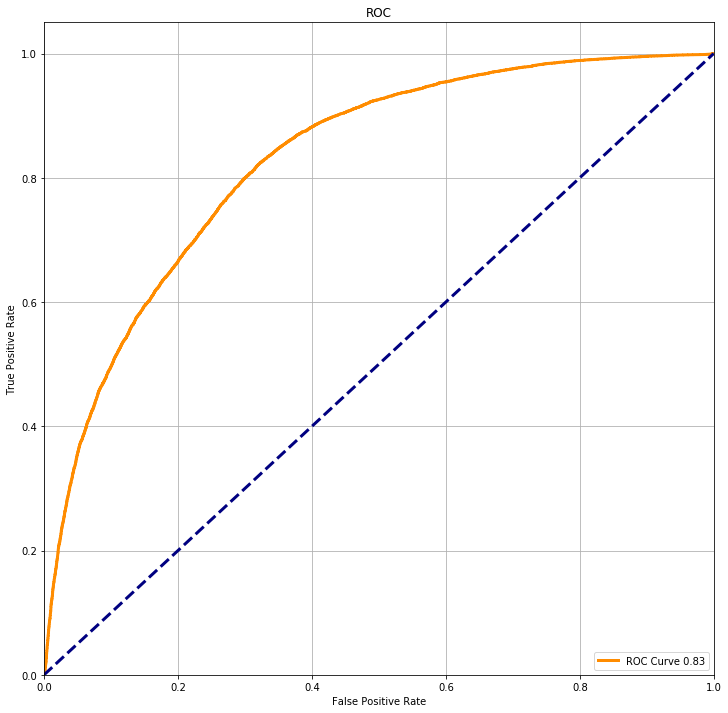

AUC: 0.8273305141038101


In [106]:
# Generate False positive rate and True positive rate
tpr, fpr, thresholds = roc_curve(y_test,df_lr['predicted_proba'], pos_label=0)
roc_auc = auc(fpr, tpr)

# Plot 
plt.figure(figsize=(12,12))
line_width = 3
plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.grid("True")
plt.legend(loc="lower right")
plt.show()

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

## We want to minimize False Positives, because there is limited harm in identifying customers as not likely to renew instead of being overconfident that they will renew.

In [107]:
def get_confusion_metric(row):    
    if row['actual_y'] == 1.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "True Positive"
    if row['actual_y'] == 1.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "False Negative"
    if row['actual_y'] == 0.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "True Negative"
    if row['actual_y'] == 0.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "False Positive"
    return row

#### Change Prediction based on a Threshold of .65 instead of the .5. We want to minimize False Positives.

In [108]:
#%%time
# Threshold of .65
df_lr.loc[:,'predicted_label'] = df_lr['predicted_proba'].map(lambda p: 1 if p > .65 else 0)
df_lr.apply(get_confusion_metric, axis = 1)['confusion_metric'].value_counts().sort_index()

False Negative     9037
False Positive     1479
True Negative     16990
True Positive      7398
Name: confusion_metric, dtype: int64

#### Create a column that says if the prediction was incorrect for analysis in Tableau

In [109]:
df_lr = df_lr[['actual_y', 'predicted_label','predicted_proba']].assign(not_equal=df_lr.actual_y != df_lr.predicted_label)

#### Merge the test predictions with the features for analysis in Tableau

In [110]:
df_lr_out = pd.merge(df, df_lr, left_index=True, right_index=True)

In [111]:
df_lr.shape

(34904, 4)

In [112]:
df_lr_out.shape

(34904, 49)

### Output test file with predicitions and predict_proba values for analysis in Tableau

In [113]:
pd.DataFrame(df_lr_out).to_csv('../datafiles/CO_2015_2016_LR.csv', index=False)